# Predicting NBA Players 2k Ratings

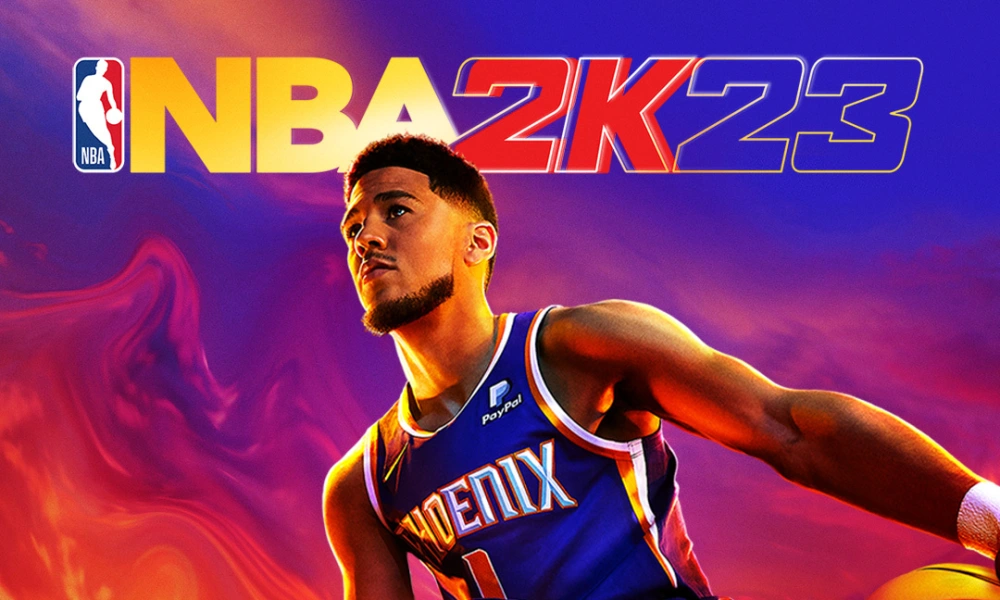

# Table Of Contents



1.   Introduction/Overview
2.   Setting Up
3.   Data Collection, Parsing, and Cleaning

4.   Data Exploration and Analysis

      *   Exploration on Points vs. 2k Rating
          *   Linear Regression Analysis
          *   K Nearest Neighbor Analysis
          *   Comparison

      *   Exploration on Points+Rebounds+Assists vs. 2k Rating
          *   Linear Regression Analysis
          *   K Nearest Neighbor Analysis
          *   Comparison
5. Conclusion







# Introduction/Overview

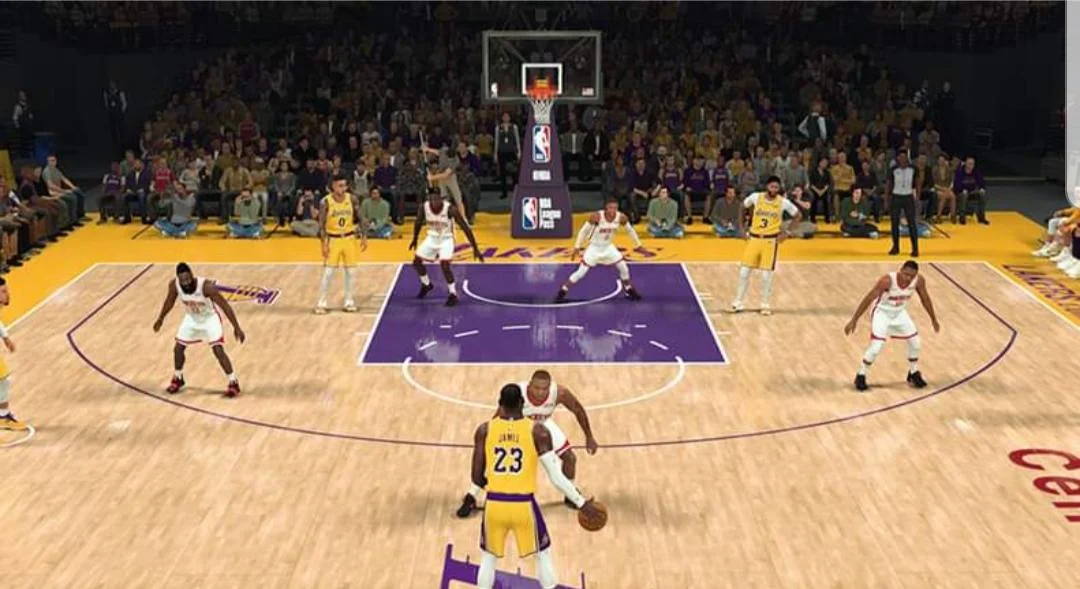

NBA: National Basketball Association

NBA 2k is a highly successful sports video game series that animates and virtualizes the world of professional basketball. Take-Two Interactive is the parent organization that is in charge of 2k Sports. 2k Sports is the company that continues to create the game series. NBA 2k is a game series that completely simulates the NBA and WNBA digitally. This means that the game digitizes the characteristics of real players like Lebron James, the courts that you would see the players on like Oracle Arena, the coaches for the teams, the mascots, and all other aspects of the NBA/WNBA viewing experience. You can find pictures of the current virtual players and more information about the game on this site.
[Current NBA 2k News](https://nba.2k.com/2k23/). You can also see the picture above for a glimpse into what the game looks like.
 
NBA 2k works on a new game every year and releases a new version of the game for purchase in September of the next year. For example, 2k23 is released in September of 2022, 2k22 is released in 2021, and so forth (this will be useful when looking at the data). NBA 2k games consist of a plethora of game modes including MyTeam, MyCareer, MyLeague, PlayNow, BlackTop, MyWNBA, and a couple of others. All of these game modes have one thing in common, the overall ratings. The rating for every player is evaluated out of 99. So in other words a 99 overall is the max rating that you a player can get. Every year when a new game is released, NBA 2k also drops a new set of 2k ratings. The 2k ratings correlate with how the player performs that year, fan favorites, and other factors. Due to this, the player ratings might be the same from year to year or they might drastically differ.
 
To start this tutorial what I wanted to do is to get data about the top 400 rated players in every NBA 2k for the past five years and then obtain the statistics they produced in the season prior to the 2K game being released. With this information, the goal is to test a couple of statistical categories like points, rebounds, and assists to see if they solely affect the rating the player receives. Then I hope to test if the combination of these statistical categories affects the prediction of the rating. The primary goal of this tutorial is to see if we can accurately predict the rating of a player based on the data we received.


# Setting Up

After scouring the internet for an NBA dataset that had all of the stats I wanted in a neat package I found out about nba_api. NBA API provides information about real game stats, player career stats, team stats, and various other NBA-related information. This is a premade API client that accesses NBA.com which holds all the data for the NBA players and presents it to the programmer in a readable and easily accessible manner. The only issue with NBA API was that if I tried to request too much information too fast the request would timeout and the cell would error. Because of this, I had to stray away from this super cool tool. I still left the information just in case you would like to learn more about it for personal use. To learn more about nba_api as a programming tool you can go to [NBA API INFO](https://github.com/swar/nba_api)

In [ ]:
pip install nba_api


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Unidecode is a project for converting Unicode to ASCII characters. For example, it can turn "ć" into "c". If you want to learn more about what it does and how you can use it go to this link [Unidecode Info](https://pypi.org/project/Unidecode/)

In [ ]:
pip install Unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import all of the neccessary tools
import requests
import numpy as np
from bs4 import BeautifulSoup
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import sqlite3 as sqlite_file
import seaborn as sns
import re
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
import statsmodels.api as sm
from unidecode import unidecode
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import neighbors
pd.set_option('display.max_columns', None)

# Data collection, Parsing, and Cleaning

I got the data for the 2k ratings of the top 400 ratings throughout the 5 years. For reference NBA 2K23 rating or the 2022-23 season refers to the rating the player received for the year 2022. I got all of the 2K ratings on [hoopshype](https://hoopshype.com/nba2k/). The data was well organized and easy to parse so it was the ideal site with the right information I needed. The function I created takes in three arguments the link for the request, the season that the rating was for, and the exact year the rating was for. A season in basketball refers to the year they played. For example, if they started to play for the year in October of 2022 then the season would be 2022-23. Since the data’s structure on the site did not differ from year to year, the parsing method stayed the same each time with only the request being different.

I combined all of the data from all of the years into one big data frame because the names of the players and years should not affect their ratings in our model. The stats they put up during the season should play heavily into the rating they get from 2K Sports. 

In [ ]:
def rating_grabber(link, year, exact):
  # Request link
  rating = requests.get(link)
  # Use bsoup to parse the html
  rating_soup = BeautifulSoup(rating.content, 'html.parser')

  elements = rating_soup.find_all('tr')
  # set columns for dictionary
  rating_dictionary = { "Rank" : [], "Name" : [], "Rating" : []}
  # read data on site and place specific data in dictionary
  for i in range(1, 401):
    # All the data in the HTML is separated by a new line and a tab so this process removes both during the appending process.
      rating_dictionary["Rank"].append(int(elements[i].findChildren("td")[0].get_text().replace('\n', '').replace('\t', '')))
      rating_dictionary["Name"].append(elements[i].findChildren("td")[1].get_text().replace('\n', '').replace('\t', ''))
      rating_dictionary["Rating"].append(int(elements[i].findChildren("td")[2].get_text().replace('\n', '').replace('\t', '')))
  rating_df = pd.DataFrame.from_dict(rating_dictionary)
  rating_df['year'] = year
  rating_df['exact'] = exact
  return rating_df
# Get data for all 5 years using rating_grabber scraping function
ratings_23 = rating_grabber("https://hoopshype.com/nba2k/",           "2021-22", 2022)
ratings_22 = rating_grabber("https://hoopshype.com/nba2k/2021-2022/", "2020-21", 2021)
ratings_21 = rating_grabber("https://hoopshype.com/nba2k/2020-2021/", "2019-20", 2020)
ratings_20 = rating_grabber("https://hoopshype.com/nba2k/2019-2020/", "2018-19", 2019)
ratings_19 = rating_grabber("https://hoopshype.com/nba2k/2018-2019/", "2017-18", 2018)
# Add all of the ratings into one big dataframe
ratings = ratings_23.append([ratings_22, ratings_21, ratings_20, ratings_19], ignore_index=True)
ratings.head(15)

,Rank,Name,Rating,year,exact
0,1,Giannis Antetokounmpo,97,2021-22,2022
1,2,Joel Embiid,96,2021-22,2022
2,2,LeBron James,96,2021-22,2022
3,2,Kevin Durant,96,2021-22,2022
4,2,Nikola Jokic,96,2021-22,2022
5,2,Stephen Curry,96,2021-22,2022
6,7,Luka Doncic,95,2021-22,2022
7,8,Kawhi Leonard,94,2021-22,2022
8,9,Jayson Tatum,93,2021-22,2022
9,9,Ja Morant,93,2021-22,2022


I plotted the 2k ratings in two ways, a scatter plot and a violin plot. The scatter plot was not ideal for analyzing the data because it made it seem as if there were only a couple of points per year when there are 400. To make it a lot easier to see the way the data is laid out I used a violin plot. The violin plot is the perfect way to see how the data is spread out and where most of the data resides.

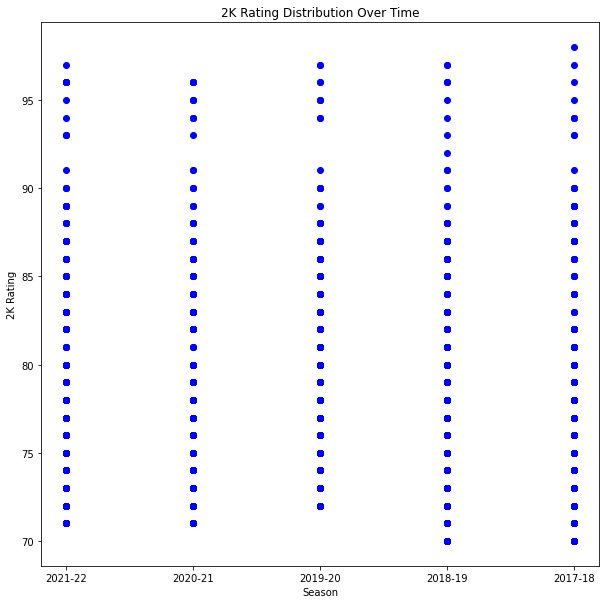

In [ ]:

# Plot all of the points as a scatter plot
fig, plot = plt.subplots(figsize=(10, 10))
plot.set_title('2K Rating Distribution Over Time')
plot.set_xlabel("Season")
plot.set_ylabel("2K Rating")
plot.scatter(ratings['year'], ratings['Rating'], color = "blue")

The distribution of 2k ratings from year to year seems to stay consistent. 2K sports likes to have a large number of players at 75 and only the best of the best above 90 overall so this distribution makes sense. All of the distributions are unimodal (with a peak around the 75 Rating mark) and skewed upward. Since the distributions are similar from year to year we can also conclude how 2k Sports calculates these ratings should also be similar or even the same from year to year. 

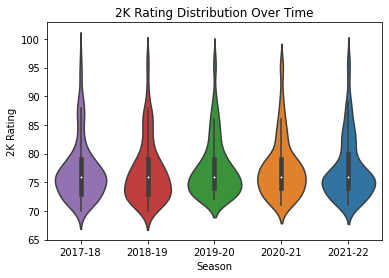

In [ ]:
v_plot = sns.violinplot(data = ratings, x="year", y="Rating", figsize=(10, 10))
v_plot.set_title('2K Rating Distribution Over Time')
v_plot.set_xlabel("Season")
v_plot.set_ylabel("2K Rating")
v_plot.invert_xaxis()

# Plot the distribution of the data as a violin plot
# x-axis for the plot is the season years and y-axis is the 2k Ratings

Many of the names that were on HoopsHype.com were not formatted such that they would be the same as some of the datasets I found. For example, a whole bunch of datasets incorporated accent marks in names, and some names had abbreviations without the "." in between the letters of the abbreviated name. To help fix this issue I replaced abbreviated names like RJ, CJ, and other names of that nature with R.J. because that was the style that the NBA player CSV had in its system. 

In [ ]:
# Get any names that had 2 capital letters back to back
# add "." in between code
for index, row in ratings.iterrows():
  if (re.search("[A-Z][A-Z]", row.Name) != None) & ((row.Name != "Glenn Robinson") | (row.Name != "Gary Payton") | (row.Name != "OG Anunoby")):
    name = row["Name"].split(" ")
    # split the names and add a "." in between the 2 letters to match up with the format of the csv file
    name[0] = name[0].replace('', '.').replace('.', '', 1)
    # switch out names
    ratings["Name"][index] = name[0] + " " + name[1]

The NBA API tool was the tool that I wanted to utilize but the tool would timeout if I accessed it more than 10 times. Since I have around 2000 elements that would not be a viable option so I decided to switch up my approach. I found a CSV online with almost the same stats. The data set I am using can be found at [Dataset](https://data.world/etocco/nba-player-stats). The cleaning that is done is converting the letters with all of the accent marks to regular English letters. For example, the unidecode function would change ć to c.




In [ ]:
players_stats = pd.read_csv("NBA_Player_Stats_2.csv")
# get only data for past 5 years
players_stats = players_stats[(players_stats.Season == "2021-22") | (players_stats.Season == "2020-21") | (players_stats.Season == "2019-20")| (players_stats.Season == "2018-19") | (players_stats.Season == "2017-18")].reset_index().drop("index", axis = 1)
# change column name for merging process
players_stats = players_stats.rename(columns ={ "Player" : "Name" , "Season" : "year"})
# convert all unicode characters within the data set into ASCII characters so that the data is a lot more readable
players_stats["Name"] =  players_stats['Name'].apply(lambda x: unidecode(x))

players_stats.head(15)

,Rk,Name,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,year,MVP
0,1,Alex Abrines,SG,24,OKC,75,8,15.1,1.5,3.9,0.395,1.1,2.9,0.380,0.4,0.9,0.443,0.540,0.5,0.6,0.848,0.3,1.2,1.5,0.4,0.5,0.1,0.3,1.7,4.7,2017-18,False
1,2,Quincy Acy,PF,27,BRK,70,8,19.4,1.9,5.2,0.356,1.5,4.2,0.349,0.4,1.0,0.384,0.496,0.7,0.9,0.817,0.6,3.1,3.7,0.8,0.5,0.4,0.9,2.1,5.9,2017-18,False
2,3,Steven Adams,C,24,OKC,76,76,32.7,5.9,9.4,0.629,0.0,0.0,0.000,5.9,9.3,0.631,0.629,2.1,3.8,0.559,5.1,4.0,9.0,1.2,1.2,1.0,1.7,2.8,13.9,2017-18,False
3,4,Bam Adebayo,C,20,MIA,69,19,19.8,2.5,4.9,0.512,0.0,0.1,0.000,2.5,4.8,0.523,0.512,1.9,2.6,0.721,1.7,3.8,5.5,1.5,0.5,0.6,1.0,2.0,6.9,2017-18,False
4,5,Arron Afflalo,SG,32,ORL,53,3,12.9,1.2,3.1,0.401,0.5,1.3,0.386,0.7,1.7,0.413,0.485,0.4,0.5,0.846,0.1,1.2,1.2,0.6,0.1,0.2,0.4,1.1,3.4,2017-18,False
5,6,Cole Aldrich,C,29,MIN,21,0,2.3,0.2,0.7,0.333,0.0,0.0,NaN,0.2,0.7,0.333,0.333,0.1,0.3,0.333,0.1,0.6,0.7,0.1,0.1,0.0,0.0,0.5,0.6,2017-18,False
6,7,LaMarcus Aldridge,C,32,SAS,75,75,33.5,9.2,18.0,0.510,0.4,1.2,0.293,8.8,16.7,0.526,0.520,4.5,5.3,0.837,3.3,5.2,8.5,2.0,0.6,1.2,1.5,2.1,23.1,2017-18,False
7,8,Jarrett Allen,C,19,BRK,72,31,20.0,3.3,5.5,0.589,0.1,0.2,0.333,3.2,5.3,0.599,0.596,1.6,2.0,0.776,2.0,3.4,5.4,0.7,0.4,1.2,1.1,2.0,8.2,2017-18,False
8,9,Kadeem Allen,PG,25,BOS,18,1,5.9,0.3,1.2,0.273,0.0,0.6,0.000,0.3,0.6,0.545,0.273,0.4,0.5,0.778,0.2,0.4,0.6,0.7,0.2,0.1,0.5,0.8,1.1,2017-18,False
9,10,Tony Allen,SF,36,NOP,22,0,12.4,2.0,4.1,0.484,0.2,0.5,0.333,1.8,3.6,0.506,0.505,0.5,1.0,0.524,0.9,1.2,2.1,0.4,0.5,0.1,0.9,2.2,4.7,2017-18,False


To preface all of this I would like to explain a couple of terms, points are when the player puts the ball into the hoop, rebounds are when a player gets the ball after a missed attempt at the hoop, and an assist is when a player gives the ball to a teammate and they score right after. Also, all of these stats are per game so for the whole year, they averaged these stats. For example, Alex Abrines averaged 4.7 points per game in 2017. The distribution of the stats seems to follow the same distribution pattern as the 2k ratings. We can see that a lot of players average around the 10-stat mark but as you go up you barely any people putting up those types of statistics. This would make sense when compared to the NBA ratings because only those very few players that are putting up major stats should receive the highest ratings.

Text(0, 0.5, 'Pts+Reb+Ast')

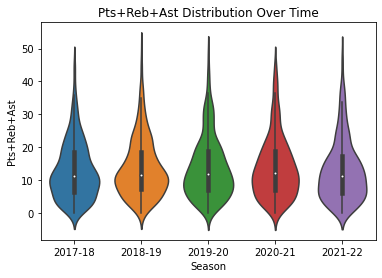

In [ ]:
# Make column for points + rebounds + assists 
players_stats['stats_important'] = players_stats.AST + players_stats.PTS + players_stats.ORB + players_stats.DRB
# plot the data
stats_plot = sns.violinplot(data = players_stats, x="year", y="stats_important", figsize=(10, 10))
stats_plot.set_title('Pts+Reb+Ast Distribution Over Time')
stats_plot.set_xlabel("Season")
stats_plot.set_ylabel("Pts+Reb+Ast")

# Plot the distribution of the data as a violin plot
# x-axis for the plot is time in years and y-axis is the Points + Rebounds + Assists 

Some players occur multiple times in the CSV for the same year. This usually means they switched teams a mid year and so their stats for that team is marked as a different row. To combat this multiple identical values for name and year, I grouped the values based on name and year then took the average. I then merged this new data frame with all the multiple values grouped and averaged with the data frame with all of the 2k ratings. This is to assign the statistics we have for the players with their adjacent 2k rating. 

After merging the two data frames so that the 2kratings would be paired up with the NBA players and their stats I saw that a couple of players had ratings but no stats for that year. After further research and personal experience, I realized that 2k Sports would rate players who just got drafted into the league so they have 0 games played and some players who had injuries that forced them to sit out for the year. These injuries made up a small number of players without stats so a lot of the NaN data was made up of players who were just drafted. Since in both cases it would be difficult to fill in stats that made sense in the situation it was best to just drop the values altogether. So we then drop all of the rows that have NaN as their values in the points, rebounds, assists, games played, or 2k ratings because these are crucial when fitting the regression models in the following analysis. 

In [ ]:
newdf1 = players_stats.groupby(['Name', 'year']).mean()
# players_stats = players_stats.drop_duplicates(subset=['Name', 'year'], keep='first')
test = pd.merge(newdf1, ratings, on = ["Name", "year"], how = "right")
test = test[(test.PTS.notnull()) & (test.AST.notnull()) & (test.ORB.notnull()) & (test.DRB.notnull()) & (test.G.notnull()) & (test.STL.notnull()) & (test.BLK.notnull()) & (test['Rating'].notnull())]
test.head(15)

,Name,year,Rk,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,MVP,stats_important,Rank,Rating,exact
0,Giannis Antetokounmpo,2021-22,12.0,27.0,67.000000,67.000000,32.9,10.300000,18.600000,0.553000,1.100000,3.600000,0.293000,9.200000,15.000000,0.616,0.582000,8.300000,11.400000,0.722000,2.0,9.600000,11.6,5.800000,1.100000,1.4,3.3,3.200000,29.900000,0.0,47.300000,1,97,2022
1,Joel Embiid,2021-22,162.0,27.0,68.000000,68.000000,33.8,9.800000,19.600000,0.499000,1.400000,3.700000,0.371000,8.400000,15.900000,0.529,0.534000,9.600000,11.800000,0.814000,2.1,9.600000,11.7,4.200000,1.100000,1.5,3.1,2.700000,30.600000,0.0,46.500000,2,96,2022
2,LeBron James,2021-22,274.0,37.0,56.000000,56.000000,37.2,11.400000,21.800000,0.524000,2.900000,8.000000,0.359000,8.600000,13.800000,0.620,0.590000,4.500000,6.000000,0.756000,1.1,7.100000,8.2,6.200000,1.300000,1.1,3.5,2.200000,30.300000,0.0,44.700000,2,96,2022
3,Kevin Durant,2021-22,154.0,33.0,55.000000,55.000000,37.2,10.500000,20.300000,0.518000,2.100000,5.500000,0.383000,8.400000,14.800000,0.568,0.570000,6.800000,7.400000,0.910000,0.5,6.900000,7.4,6.400000,0.900000,0.9,3.5,2.100000,29.900000,0.0,43.700000,2,96,2022
4,Nikola Jokic,2021-22,290.0,26.0,74.000000,74.000000,33.5,10.300000,17.700000,0.583000,1.300000,3.900000,0.337000,9.000000,13.800000,0.652,0.620000,5.100000,6.300000,0.810000,2.8,11.000000,13.8,7.900000,1.500000,0.9,3.8,2.600000,27.100000,1.0,48.800000,2,96,2022
5,Stephen Curry,2021-22,126.0,33.0,64.000000,64.000000,34.5,8.400000,19.100000,0.437000,4.500000,11.700000,0.380000,3.900000,7.400000,0.527,0.554000,4.300000,4.700000,0.923000,0.5,4.700000,5.2,6.300000,1.300000,0.4,3.2,2.000000,25.500000,0.0,37.000000,2,96,2022
6,Luka Doncic,2021-22,141.0,22.0,65.000000,65.000000,35.4,9.900000,21.600000,0.457000,3.100000,8.800000,0.353000,6.800000,12.800000,0.528,0.529000,5.600000,7.500000,0.744000,0.9,8.300000,9.1,8.700000,1.200000,0.6,4.5,2.200000,28.400000,0.0,46.300000,7,95,2022
8,Jayson Tatum,2021-22,526.0,23.0,76.000000,76.000000,35.9,9.300000,20.600000,0.453000,3.000000,8.600000,0.353000,6.300000,12.000000,0.524,0.526000,5.300000,6.200000,0.853000,1.1,6.900000,8.0,4.400000,1.000000,0.6,2.9,2.300000,26.900000,0.0,39.300000,9,93,2022
9,Ja Morant,2021-22,390.0,22.0,57.000000,57.000000,33.1,10.200000,20.600000,0.493000,1.500000,4.500000,0.344000,8.600000,16.200000,0.534,0.530000,5.500000,7.300000,0.761000,1.4,4.400000,5.7,6.700000,1.200000,0.4,3.4,1.500000,27.400000,0.0,39.900000,9,93,2022
10,Jimmy Butler,2021-22,87.0,32.0,57.000000,57.000000,33.9,7.000000,14.500000,0.480000,0.500000,2.000000,0.233000,6.500000,12.500000,0.520,0.496000,6.900000,8.000000,0.870000,1.8,4.100000,5.9,5.500000,1.600000,0.5,2.1,1.500000,21.400000,0.0,32.800000,9,93,2022


To see if the data follows the same distribution after cleaning and dropping unnecessary information from the original dataset I plotted the same statistics in violin plot form. As expected the data follows the same distribution while being unimodal and skewed upward. The only difference is that there is a peak around the 15-stat mark whereas previously the mark was around the 10-stat mark.

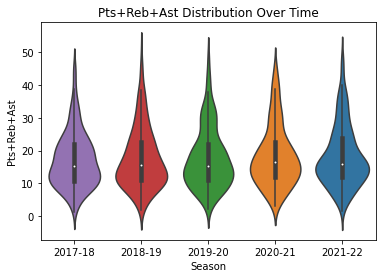

In [ ]:
# Make column for points + rebounds + assists for our final data fully cleaned data set
test['pts_reb_ast'] = test.AST + test.PTS + test.ORB + test.DRB

# plot the data
pl = sns.violinplot(data = test, x="year", y="pts_reb_ast", figsize=(10, 10))
pl.set_title('Pts+Reb+Ast Distribution Over Time')
pl.set_xlabel("Season")
pl.set_ylabel("Pts+Reb+Ast")
pl.invert_xaxis()

# Plot the distribution of the data as a violin plot
# x-axis for the plot is time in years and y-axis is the Points + Rebounds + Assists 

# Data Exploration and Analysis

# Exploration on Points vs 2k Rating


The goal of this tutorial is to find a number rating that corresponds to the stats that the player produces so this would be classified as a regression problem. I want to use 2 different regression methods to try to predict the rating. I have to use the original linear regression and then I want to see how well KNN Regressor does when predicting the rating. The questions I want to answer are 1 "Is there a relationship between Points and 2kRating?"
2 "How much of a relationship?"
3 Repeat for pts+reb+ast
4 Then use KNN Regressor


First I want to use just the points stat to predict the rating because, in theory, the person that produces the most points should be the best player and thus have the highest rating. This is only in theory because basketball in real life is not only revolved around getting points. You have to be versatile and be able to produce in all aspects of the game to be considered a really good player. Because of this, we will then move onto linear regression with interaction terms between points, rebounds, and assists because they should all affect the rating. After the interaction term linear regression, I want to try out the regression with the pts+ast+reb column we used to plot the violin plots in the previous part.

Text(0, 0.5, '2k Rating')

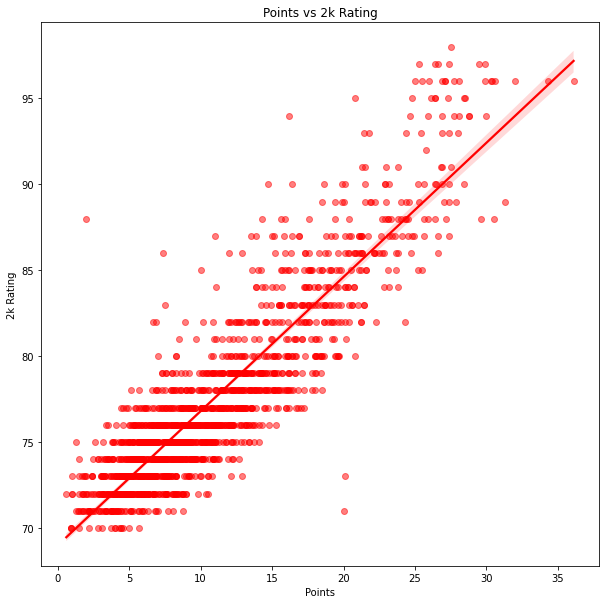

In [ ]:
# Plot Points vs. 2k Ratings
fig, t_plot = plt.subplots(figsize=(10, 10))
t_plot = sns.regplot(test.PTS, test.Rating, color = "red", scatter_kws={'alpha':0.5})
t_plot.set_title('Points vs 2k Rating')
t_plot.set_xlabel("Points")
t_plot.set_ylabel("2k Rating")
# x-axis for the plot is Points and y-axis is the 2k Rating

We can see that as the number of points increases so do the 2kratings. There is a clear linear correlation between points and a 2k rating but the goal is to see how much of a correlation and to try to predict future ratings based on points alone.

# Linear Regression Analysis

In [ ]:
extra = pd.DataFrame(columns = ["Algorithm", "Ind Var", "Mean Absolute Error", "R2"])
# declare and intialize linear regression object
linear = linear_model.LinearRegression()
print("Average Player: " + str(test['PTS'].mean()) + ", " + str(test['Rating'].mean()))

pts = test['PTS'].array
rating = test['Rating'].array  
# Fit the model with points array and 2k Rating data from data frame
linear.fit(pts.reshape(-1, 1), rating)

# Use ordinary least squares to fit the data and use ols to read only the array and 2k Rating data.
first = sm.OLS.from_formula('Rating ~ PTS', test).fit()
corr, _ = pearsonr(test['PTS'],  test['Rating'])
# Using the linear regression object print the coefficient and intercept from the model
print("Linear Regression Formula: " + str(linear.coef_[0]) + "x + " + str(linear.intercept_) + "\n")
print("Mean Residuals: " + str(abs(first.resid).mean()))
print("Pearson Correlation: " + str(corr))

# Double check the values are correct by running the ols summary to compare the coefficients and intercepts
first.summary()

Average Player: 11.00954756146715, 77.58645707376058
Linear Regression Formula: 0.781094457673584x + 68.98696049200487

Mean Residuals: 1.8422989081814336
Pearson Correlation: 0.8916107267764348


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     6405.
Date:                Thu, 15 Dec 2022   Prob (F-statistic):               0.00
Time:                        00:18:01   Log-Likelihood:                -3836.4
No. Observations:                1654   AIC:                             7677.
Df Residuals:                    1652   BIC:                             7688.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     68.9870      0.123    559.355      0.000      68.745      69.229
PTS            0.7811      0.010     80.033      0.000       0.762       0.800
==============================================================================
Omnibus:                      251.152   Durbin-Watson:                   1.546
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              918.037
Skew:                           0.714   Prob(JB):                    4.48e-200
Kurtosis:                       6.359   Cond. No.                         25.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can see that there is a positive correlation between the independent variable, points, such that as the number of points increases so does the 2k rating. From the regression formula we can see that for every one point a player increases they increase their total rating by .781. We can see that the average player scores around 11 points per game and are listed at a 78 rating. This can be used as a basis for classifying and rating great players because many of the players who are rated in the 90s are averaging above 20 points per game. We can see that there is a correlation before a correlation test is even administered purely off on the analysis of the stats. As a cherry on top according to the Pearson correlation test we can see that the correlation between points and rating is 0.8916107267764348. This suggests that there is a strong positive correlation between the two which is then supported by our linear regression.

In [ ]:
# Get the independent and dependent variable for the linear regression model
# In this case it is points as independent variable and 2k rating as dependent
X,Y = test[['PTS']], test.Rating
x_train, x_test,y_train,y_test = train_test_split(X,Y,test_size =0.2)
linear_test = linear_model.LinearRegression()

# fit the model with the training set
linear_test.fit(x_train,y_train)
linear_test.predict(x_test)
# test and score the model with the test set
print("Linear Regression Test Set R2: " + str(linear_test.score(x_test,y_test)))
# run 10 fold cross validation on mean absolute error to evaluate the model
scores_lin_pts = cross_val_score(linear_test, X, Y, scoring='neg_mean_absolute_error', cv=10)
extra = extra.append({"Algorithm": "Linear Regression", "Ind Var": "Points", "Mean Absolute Error" : abs(scores_lin_pts).mean(),"R2": linear_test.score(x_test,y_test)}, ignore_index = True)
print("Linear Regression 10 Fold Cross Validation Scores: " + str(abs(scores_lin_pts)) + "\n")
print("Linear Regression Mean Absolute Error of 10 Fold Cross Validation: "  + str(abs(scores_lin_pts).mean()))

Linear Regression Test Set R2: 0.8386101840089352
Linear Regression 10 Fold Cross Validation Scores: [2.12173905 1.59765624 2.16245645 1.60199682 1.89244352 1.47868778
 2.16823212 1.69421653 2.27201333 1.63549204]

Linear Regression Mean Absolute Error of 10 Fold Cross Validation: 1.8624933875119285


We can see that the after fitting the model with the training data and scoring the test data the R2 value is about 0.82. This is a value close to one so this would indicate that we can assume that the linear regression model is a good fit for the dependent variable. To confirm this I performed a 10 Fold Cross Validation based on the Mean absolute error. Based on the results of the 10 Fold Cross validation we can see the average mean absolute error is relatively low. We can interpret this as the error between the prediction and the actual value is around 1.86 overall. To put this in perspective the average 2k rating is about 78 so if the average of the absolute error between the prediction and the actual value is about 2 percent of the total value then we can say that the prediction is relatively accurate. 

# K Nearest Neighbor Analysis

To have some fun and mess around I wanted to test out how the KNN regressor would do with predicting 2k ratings based on the points alone. Since many of the neighbors to the points will have around the same points scored I expect the algorithm to do decently well when predicting ratings because the ratings close by should be a good representation of what rating the prediction point should be. KNN is not the only regression algorithm I could have chosen but I based on the data and situation I wanted to use this algorithm specifically. If you want to see the other options for machine learning algorithms you can go here [ML Algorithms](https://scikit-learn.org/stable/)

Hyperparameter tuning is crucial when trying to apply a machine learning model because it will a really good hyperparameter value will in turn allow the model to be the best it can be. The hyperparameter for K nearest neighbor is K. So the number of neighbors it will look at to predict the next value. To find the best k I am using a popular method for hyperparameter tuning called grid search cv. If you want to learn about gridsearchcv you can go here [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) Grid search cv is not the only hyperparameter tuning function but seemed the most straight forward so I used it. There are a couple of others like random search, Bayesian Optimization, etc. 

In [ ]:
# declare and intialize linear regression object
neigh_pts = neighbors.KNeighborsRegressor()
parameters = [{'n_neighbors': [2, 3, 4, 5, 6, 7 , 8, 9, 10]}]
# Find best K using gridsearchcv
param_search = GridSearchCV(neigh_pts, parameters, scoring = 'neg_mean_absolute_error', cv = 5)
param_search.fit(X, Y)
print(param_search.best_params_)
# The process to find the best hyperparameter for the KNN algorithn helps us get the best result possible.
# By finding how many neighbors to search for and compare the algorithm is a lot better at predicting the next value.


{'n_neighbors': 10}


In [ ]:
# Get the independent and dependent variable for the KNN regression model
# In this case it is points as independent variable and 2k rating as dependent

# fit the model with the training set
neigh_pts.fit(x_train,y_train)
neigh_pts.predict(x_test)
# test and score the model with the test set
print("KNN Test Set R2: " + str(neigh_pts.score(x_test,y_test)))
# run 10 fold cross validation on mean absolute error to evaluate the model
scores_pts = cross_val_score(neigh_pts, X, Y, scoring='neg_mean_absolute_error', cv=10)
extra = extra.append({"Algorithm": "K Nearest Neighbor Regression", "Ind Var": "Points", "Mean Absolute Error" : abs(scores_pts).mean(),"R2": neigh_pts.score(x_test,y_test)}, ignore_index = True)

print("KNN 10 Fold Cross Validation Scores: " + str(abs(scores_pts)) + "\n")
print("KNN Mean Absolute Error of 10 Fold Cross Validation: "  + str(abs(scores_pts).mean()))


KNN Test Set R2: 0.8127829285872668
KNN 10 Fold Cross Validation Scores: [2.40963855 1.76024096 2.44939759 1.64457831 2.14424242 1.52969697
 2.42060606 1.76848485 2.30545455 1.68727273]

KNN Mean Absolute Error of 10 Fold Cross Validation: 2.0119612997444323


We can see that the R2 for the KNN is around 0.8. This is relatively close to 1 so this would me that this model is a good fit for the dependent variable. We can see that the average mean absolute error is about 2.01. This is a relatively low absolute in terms of a 2k rating because the rating average is about 78. The mean absolute error is about 2 percent of the total rating so the model is a good fit for the data. Because the mean absolute value is low we can accurately predict the 2k ratings based on the points.

# Comparison

In [ ]:
extra

,Algorithm,Ind Var,Mean Absolute Error,R2
0,Linear Regression,Points,1.862493,0.838610
1,K Nearest Neighbor Regression,Points,2.011961,0.812783


Both algorithms are very similar in terms of R2 and mean absolute error but linear regression takes a slight edge in both evaluation methods. When it comes to R2, the linear regression method was always slightly higher than the KNN algorithm. Both are relatively good but linear regression is better a fit for the dependent variable. When it came to mean absolute error, the linear regression algorithm was around 1.86 while the KNN algorithm was around 2.01. We can see that linear regression has about 8 percent less mean absolute error than KNN. We can see that both algorithms can be used in this situation but in terms of better predictions, we can stick with the linear regression because we want to reduce the amount of error between predicted and actual values as much as possible.

# Exploration on Points+Rebounds+Assists vs. 2k Rating

Points are only a part of the story when finding a good player. Being able to rebound the ball and assist your teammates along with being able to score is what differentiates great players from average players. So in terms of 2k ratings, the number of Points, Rebounds, and Assists should all affect that rating. To account for this I decided to add up all of the stats together and create a separate column for that stat. In this way, it's a lot easier to understand and a lot easier to compute manually. Based on the pts in the previous section, we should see a similar trend such that an increase in the Points+Rebounds+Assists mark should be linked with an increase in rating.

Text(0, 0.5, '2k Rating')

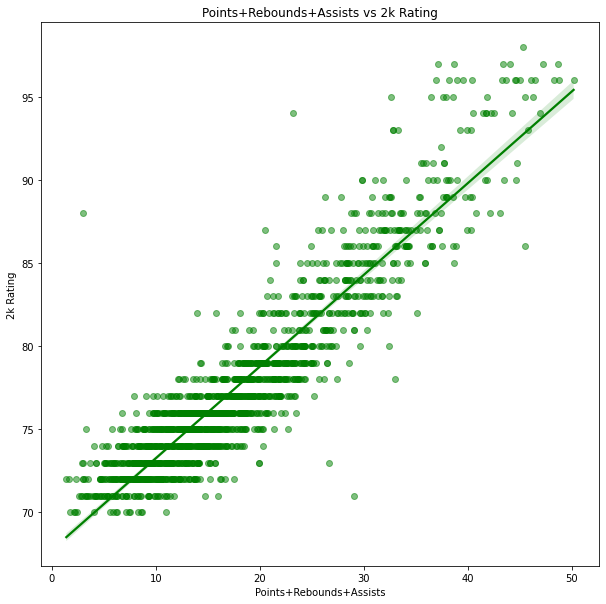

In [ ]:
# Plot Points+Rebounds+Assists vs. 2k Ratings
fig, t_plot = plt.subplots(figsize=(10, 10))
t_plot = sns.regplot(test.pts_reb_ast, test.Rating, color = "green", scatter_kws={'alpha':0.5})
t_plot.set_title('Points+Rebounds+Assists vs 2k Rating')
t_plot.set_xlabel("Points+Rebounds+Assists")
t_plot.set_ylabel("2k Rating")
# x-axis for the plot is Points+Rebounds+Assists and y-axis is the 2k Rating

Like the points plot, we can see that the stats combined also tend to have a positive linear correlation. This graph seems to be a little more tightly wound along the regression line so this should have a better ability to predict 2k ratings since we get also get a better picture of the player since we have more than one stat to base the prediction of.

# Linear Regression Analysis

In [ ]:
# declare and intialize linear regression object
linear_imp_stats = linear_model.LinearRegression()
print("Average Player: " + str(test['pts_reb_ast'].mean()) + ", " + str(test['Rating'].mean()))

stat_imp = test['pts_reb_ast'].array
rating = test['Rating'].array  
# Fit the model with Points+Rebounds+Assists array and 2k Rating data from data frame
linear_imp_stats.fit(stat_imp.reshape(-1, 1), rating)

# Use ordinary least squares to fit the data and use ols to read only the array and 2k Rating data.
first_imp = sm.OLS.from_formula('Rating ~ pts_reb_ast', test).fit()
corr, _ = pearsonr(test['pts_reb_ast'],  test['Rating'])
# Using the linear regression object print the coefficient and intercept from the model
print("Linear Regression Formula: " + str(linear_imp_stats.coef_[0]) + "x + " + str(linear_imp_stats.intercept_) + "\n")
print("Mean Residuals: " + str(abs(first_imp.resid).mean()))
print("Pearson Correlation: " + str(corr))
# Double check the values are correct by running the ols summary to compare the coefficients and intercepts
first_imp.summary()

Average Player: 17.859356106408708, 77.58645707376058
Linear Regression Formula: 0.5512674358386024x + 67.74117562725218

Mean Residuals: 1.5802925807184853
Pearson Correlation: 0.9200346799349055


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     9108.
Date:                Thu, 15 Dec 2022   Prob (F-statistic):               0.00
Time:                        00:18:02   Log-Likelihood:                -3597.2
No. Observations:                1654   AIC:                             7198.
Df Residuals:                    1652   BIC:                             7209.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      67.7412      0.116    585.463      0.000      67.514      67.968
pts_reb_ast     0.5513      0.006     95.434      0.000       0.540       0.563
==============================================================================
Omnibus:                      351.875   Durbin-Watson:                   1.620
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2668.851
Skew:                           0.783   Prob(JB):                         0.00
Kurtosis:                       9.023   Cond. No.                         44.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We assumed that there was a positive correlation between the pts+reb+ast and 2k rating from the observations made in the graph. There is clear statistical evidence backing this claim because we can see that the coefficient for the regression line is positive. This positive coefficient indicates that for 1 stat the pts+reb+ast increases the 2k rating increases by 0.551267435. We can see that the average player produces around 17.85 pts+reb+ast and the average player has a 2k rating of about 78. Again this can be used as a basis/level 0 to work off of because if a player produces less or produces more they become a better/worse player which should correlate to their rating fluctuating based on performance.

We can see from the graph and the linear regression line formula that there is a pattern that the 2k ratings follow that somewhat follow the pts+reb+ast. To confirm there is a correlation we can see that the Pearson correlation test has a result of 0.9200346799349055. This means that there is a very strong positive correlation between pts+reb+ast and 2k rating. Compared to points alone to the pts+reb+ast stat, pts+reb+ast is 0.028423953158470683 higher in terms of correlation test results. This would indicate that there is more of a correlation between pts+reb+asts and 2k rating than between just points and 2k rating.


In [ ]:
# Get the independent and dependent variable for the linear regression model
# In this case it is points as independent variable and 2k rating as dependent
X_all,Y_all = test[['pts_reb_ast']], test.Rating
x_train_all, x_test_all,y_train_all,y_test_all = train_test_split(X_all,Y_all,test_size =0.2)
linear_test_imp = linear_model.LinearRegression()
# fit the model with the training set
linear_test_imp.fit(x_train_all,y_train_all)
linear_test_imp.predict(x_test_all)
# score the model for the test sets
print("Test Set R2: " + str(linear_test_imp.score(x_test_all,y_test_all)))
# run the 10 fold cross validation based on mean absolute error to evaluate model
scores = cross_val_score(linear_test_imp, X_all, Y_all, scoring='neg_mean_absolute_error', cv=10)
extra = extra.append({"Algorithm": "Linear Regression", "Ind Var": "Pts+Reb+Ast", "Mean Absolute Error" : abs(scores).mean(),"R2": linear_test_imp.score(x_test_all,y_test_all)}, ignore_index = True)
print("10 Fold Cross Validation Scores: " + str(abs(scores)) + "\n")
print("Mean Absolute Error of 10 Fold Cross Validation: "  + str(abs(scores).mean()))

Test Set R2: 0.810565125522513
10 Fold Cross Validation Scores: [1.708322   1.47864001 1.68172122 1.51169917 1.45483377 1.44182014
 1.67393295 1.6008755  1.87654215 1.46933385]

Mean Absolute Error of 10 Fold Cross Validation: 1.5897720782724354


Compared to just points the R2 is around is a lot higher. The points R2 would be around the 0.82 mark but the pts+reb+ast has an R2 that is around the 0.85-0.87 mark. We can see that the linear regression model for pts+reb+ast is definitely a good fit for the dependent variable, 2k rating. The mean absolute error is also relatively much lower. The average mean absolute error went from around 1.86 to about 1.59. That is about 16% less error when using pts+reb+ast as opposed to just pts. We can see that because there is less error the regression line would be able to predict 2k ratings at a much more accurate and efficient rate.

# K Nearest Neighbor Analysis

Again to have some fun, I wanted to see how well the KNN regressor algorithm did with the pts+reb+asts stat. So I implemented the same tactics for hyperparameter tuning as I did in the KNN for points and went on to test the KNN algorithm with the pts+reb+ast and 2k rating data

In [ ]:
# declare and intialize linear regression object
neigh_all = neighbors.KNeighborsRegressor()
parameters = [{'n_neighbors': [2, 3, 4, 5, 6, 7 , 8, 9, 10]}]
# Find best K using gridsearchcv
param_search = GridSearchCV(neigh_all, parameters, scoring = 'neg_mean_absolute_error', cv = 5)
param_search.fit(X_all, Y_all)
print(param_search.best_params_)
# The process to find the best hyperparameter for the KNN algorithn helps us get the best result possible.
# By finding how many neighbors to search for and compare the algorithm is a lot better at predicting the next value.


{'n_neighbors': 10}


In [ ]:
# Get the independent and dependent variable for the KNN regression model
# In this case it is points as independent variable and 2k rating as dependent
# fit the mode with the training sets
neigh_all.fit(x_train_all,y_train_all)
# predict the prediction for the test set
neigh_all.predict(x_test_all)
# score for the test set
print("KNN All Test Set R2: " + str(neigh_all.score(x_test_all,y_test_all)))
# run the 10 fold cross validation based on mean absolute error to evaluate model
scores_all = cross_val_score(neigh_all, X_all, Y_all, scoring='neg_mean_absolute_error', cv=10)
# add data to ml algo results data frame
extra = extra.append({"Algorithm": "K Nearest Neighbor Regression", "Ind Var": "Pts+Reb+Ast", "Mean Absolute Error" : abs(scores_all).mean(),"R2": neigh_all.score(x_test_all,y_test_all)}, ignore_index = True)

print("KNN All 10 Fold Cross Validation Scores: " + str(abs(scores_all)) + "\n")
print("KNN All Mean Absolute Error of 10 Fold Cross Validation: "  + str(abs(scores_all).mean()))


KNN All Test Set R2: 0.8021170457705431
KNN All 10 Fold Cross Validation Scores: [1.81927711 1.41927711 1.94698795 1.41325301 1.74060606 1.26787879
 1.79151515 1.67272727 1.95757576 1.34545455]

KNN All Mean Absolute Error of 10 Fold Cross Validation: 1.637455275648047


The R2 for all of the algorithms we have used has been relatively good. Since the value of R2 is close to 1, we can say that the model is a good fit for the dependent variable, a 2k rating. When we turn over to the scores of the 10 fold cross validation scores we can see that the average absolute mean error was around the 1.63 mark. This means that the average amount that we are usually off from the prediction is about 1.63. This is a good error to have because the average for a 2k rating is around 78 so we are only off by 1 or 2 ratings when predicting. The KNN for points was worse in terms of absolute mean error and R2 so we can see the improvement from just pts to pts+reb+ast.

# Comparison

In [ ]:
extra

,Algorithm,Ind Var,Mean Absolute Error,R2
0,Linear Regression,Points,1.862493,0.838610
1,K Nearest Neighbor Regression,Points,2.011961,0.812783
2,Linear Regression,Pts+Reb+Ast,1.589772,0.810565
3,K Nearest Neighbor Regression,Pts+Reb+Ast,1.637455,0.802117


Like in the points vs. 2k rating analysis we can see that the linear regression model tends to have a slight edge over KNN. When it came to R2, the linear regression model was consistently around the 0.85-0.87 mark while the KNN algorithm was in the 0.82 area. This would allow us to assume that the linear regression fits the 2k ratings better. From the plots, we can see the linear relationship between pts+reb+ast and 2k rating so this would make sense. Again in the mean absolute error, we can see a slight discrepancy between KNN and linear regression. The linear regression algorithm for pts+reb+ast seems to be the best fit for a 2k rating and this directly correlates to having the least mean absolute error.




# Conclusion

All of the training models and results of these models were relatively good. They all showed us that it is possible to predict a player's 2k rating off either just points or points, rebounds, and assists pretty accurately. Even though all of the models resulted in low mean absolute errors when the 10-fold cross-validation was done, the best R2 score and lowest mean absolute error were definitely for the pts+reb+ast linear regression. Based on the plots in that section we could have observed the linear relationship between the independent variable and dependent variable and based on this observation it would have been clear that linear regression would be best in this situation. I expected K nearest neighbor to compete with linear regression because the stats had a lot of clusters. This would indicate that many of the ratings that were close by would also have the same stats. So if the prediction landed next to good neighbors then the ability for that model to predict the 2k rating should be accurate.

Based on the linear regression model for pts+reb+ast we can accurately predict the 2k rating for the player if we are given the number of points, assists, and rebounds they average within a year. To test this theory the best way is to predict the ratings for a data set that has not been rated yet and then compare when the ratings are released.

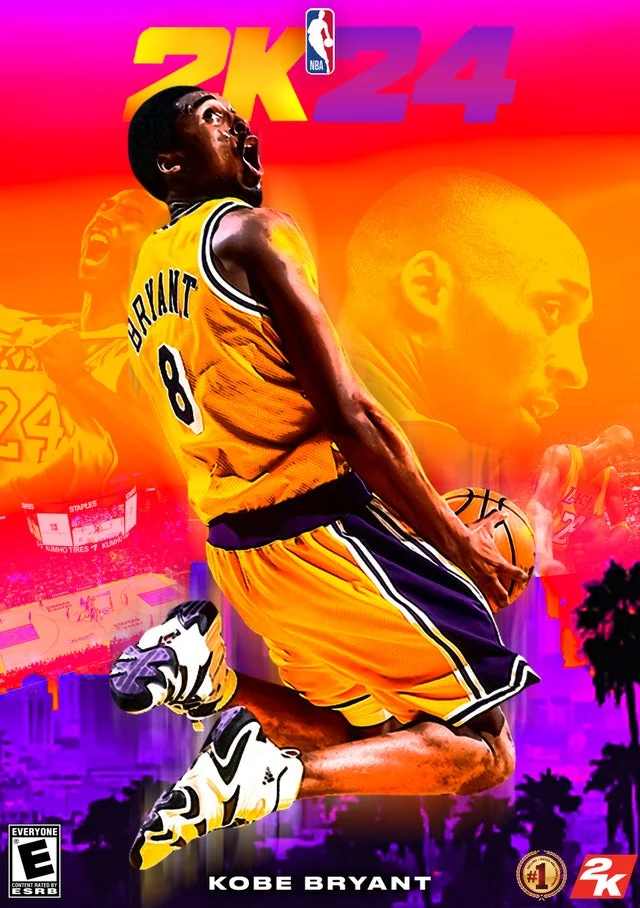

As a final test, I gathered the data for the players as of December 14, 2022, and cleaned the data. Using this data, I wanted to predict the 2k rating for the players for 2k24. The model I choose was the one we decided was the best model to work with since it had the highest R2 and lowest mean absolute value. Using the pts+reb+ast linear regression model I predicted the 2k rating for the players based on how they have been playing so far. The goal is to come back in September 2023 when 2k24 releases and check how accurate the predictions were.

In [ ]:
# Get data for 2022 year
players_stats_2023 = pd.read_excel('/content/NBA Stats 202223 All Player Statistics in one Page.xlsx')
# Name the columns since for some reason the data did not come labeled
players_stats_2023.columns = ['random', 'Name', 'Team', 'Pos', 'Age', "GP", 'MPG', "Min%", "USG%", "TO%", "FTA", "FT%", "2PA", "2P%", "3PA", "3P%", "eFG%", "TS%", "PPG", "RPG", "TRB%", "APG", "AST%", "SPG", "BPG", "TOPG", "VI", "ORTG", "DRTG"]
# Drop columns because they had NaN values and are not needed for prediction
players_stats_2023 = players_stats_2023.drop(columns = {'random', "ORTG", "DRTG" })
# Drop first row with unnecessary information 
players_stats_2023 = players_stats_2023.drop( index = 0, axis = 0)
# Get pts+reb+ast for the 2022 dataset
players_stats_2023["pts_reb_ast"] = players_stats_2023.PPG + players_stats_2023.RPG + players_stats_2023.APG 
# get the predictions from the model based on the pts+reb+ast
players_stats_2023["rating"] = linear_test_imp.predict(players_stats_2023[["pts_reb_ast"]])
# switch rating to be in the first column so it is easily seen
first_column = players_stats_2023.pop('rating')
players_stats_2023.insert(0, 'rating', first_column)
players_stats_2023.head(15)

,rating,Name,Team,Pos,Age,GP,MPG,Min%,USG%,TO%,FTA,FT%,2PA,2P%,3PA,3P%,eFG%,TS%,PPG,RPG,TRB%,APG,AST%,SPG,BPG,TOPG,VI,pts_reb_ast
1,77.127487,Precious Achiuwa,Tor,F,23.24,12,20.4,42.5,21,12.3,33,0.848,64,0.484,28,0.179,0.418,0.493,8.8,7,19.4,1.3,9.5,0.17,0.58,1.25,8.5,17.1
2,79.164734,Steven Adams,Mem,C,29.4,24,26.7,55.6,14.2,23.1,65,0.292,140,0.614,1,0,0.61,0.563,8,10.5,21,2.3,11.5,0.79,1.04,2.13,8.7,20.8
3,86.212506,Bam Adebayo,Mia,C-F,25.41,26,35,73,26.2,14.4,139,0.842,391,0.54,10,0.1,0.53,0.586,20.8,9.5,15.5,3.3,16.9,0.96,0.73,3,9.9,33.6
4,70.134776,Ochai Agbaji,Uta,G,22.65,12,9,18.7,13.6,0,7,0.571,18,0.556,14,0.286,0.5,0.513,3,1.3,7.6,0.1,1.2,0.08,0,0,3.2,4.4
5,77.182548,Santi Aldama,Mem,F-C,21.93,26,24.7,51.5,15.3,6.7,51,0.745,102,0.578,98,0.357,0.558,0.587,10,5.8,12.4,1.4,7.5,0.85,0.92,0.62,7,17.2
6,73.438419,Nickeil Alexander-Walker,Uta,G,24.28,19,14.6,30.4,19.4,19.5,19,0.737,43,0.535,52,0.442,0.605,0.624,6.8,1.6,6.1,2,19.1,0.63,0.37,1.32,7.6,10.4
7,77.237609,Grayson Allen,Mil,G,27.18,24,27.4,57.1,15,12.4,57,0.93,68,0.529,112,0.42,0.592,0.649,11.1,3.6,6.9,2.6,13.3,0.75,0.21,1.21,6.9,17.3
8,82.027891,Jarrett Allen,Cle,C,24.65,21,32.7,68.2,17.4,13.7,77,0.74,196,0.617,3,0,0.608,0.642,14.2,10.5,18.8,1.3,6.3,0.67,1.33,1.76,7.1,26.0
9,75.916151,Jose Alvarado,Nor,G,24.67,27,20.8,43.2,19.7,14.6,39,0.769,97,0.536,108,0.38,0.554,0.578,9.5,2.2,5.9,3.2,21.3,1.3,0.15,1.41,7.8,14.9
10,75.916151,Kyle Anderson,Min,F-G,29.23,22,23.7,49.5,13.3,20,44,0.841,90,0.522,23,0.435,0.549,0.608,7.3,4.2,9.7,3.4,18.6,1.05,0.82,1.5,7.9,14.9
